# Ejercicio Europa

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys; sys.path.append("..")
from src.kohonen import Kohonen

In [2]:
def get_data():
    df = pd.read_csv("../data/europe.csv")
    df = df.set_index("Country")
    return df


## Red Kohonen

* Asociar países que posean las mismas características geopolíticas, económicas y sociales.
* Realizar al menos un gráfico que muestre los resultados.
* Realizar un gráfico que muestre las distancias promedio entre neuronas vecinas.
* Analizar la cantidad de elementos que fueron asociados a cada neurona.

In [3]:
np.random.seed(0)

data = get_data()
norm_data = (data - data.mean()) / data.std()

dims_out = (3, 3)
som = Kohonen(
    len(norm_data.columns),
    dims_out
)

som.train(norm_data.values, epochs=100, decay=True)
pred = som.predict(norm_data.values)

El gráfico muestra una buena clusterización, más adelante podemos hacer un cluster sobre las variables de mayor varianza, usando el modelo de Oja.

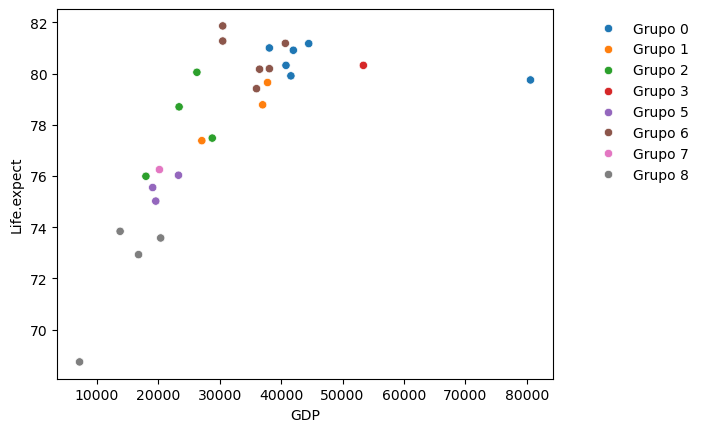

In [4]:
data["grupos"] = ["Grupo {}".format(np.ravel_multi_index(p, dims_out)) for p in pred]
sns.scatterplot(
    data=data,
    x="GDP",
    y="Life.expect",
    hue="grupos",
    hue_order=sorted(data["grupos"].unique()),
    palette="tab10"
)
plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()

Se observa que hay grupos que tienen sentido con respecto a su ubicación espacial:

* Grupo 0 y 1: Paises pequeños de Europa Central.
* Grupo 8: Paises de Europa Oriental.
* Grupo 6: Paises con gran área GDP y Expectativa de vida.


In [5]:
pt = data.reset_index().pivot_table("Country", "grupos", aggfunc=lambda s: ", ".join(s))
pt["Count"] = pt.Country.str.split(",").apply(lambda x: len(x))
pt

,Country,Count
grupos,,
Grupo 0,"Austria, Iceland, Ireland, Luxembourg, Netherl...",6
Grupo 1,"Belgium, Czech Republic, Denmark",3
Grupo 2,"Croatia, Greece, Portugal, Slovenia",4
Grupo 3,Norway,1
Grupo 5,"Hungary, Lithuania, Slovakia",3
Grupo 6,"Finland, Germany, Italy, Spain, Sweden, United...",6
Grupo 7,Poland,1
Grupo 8,"Bulgaria, Estonia, Latvia, Ukraine",4


## Modelo de Oja

* Calcular la primer componente principal para este conjunto de datos.
* Interpretar el resultado de la primer componente.
* Comparar el resultado del ejercicio de Oja con el resultado de calcular la primer componente principal con una librería.

In [6]:
from src.oja import Oja
from numpy.linalg import norm

In [7]:
data = get_data()
norm_data = (data - data.mean()) / data.std()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(norm_data.values)
pc1_skl = pca.components_[0]

Epoca 0: ángulo de 130° respecto a PC1
Epoca 20: ángulo de 173° respecto a PC1
Epoca 40: ángulo de 173° respecto a PC1
Epoca 60: ángulo de 173° respecto a PC1
Epoca 80: ángulo de 173° respecto a PC1


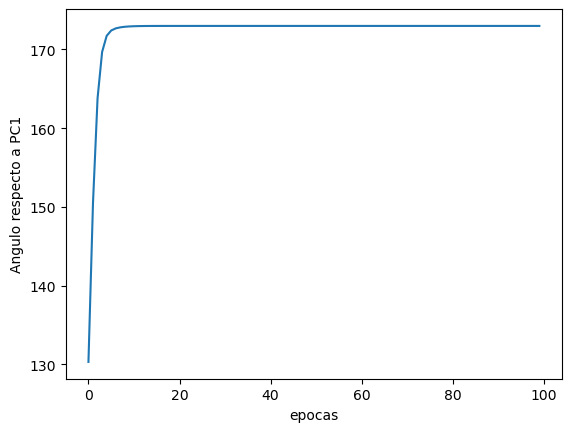

In [8]:
oja = Oja(input_size=len(data.columns), n_components=1)

epochs = 100
angulos = []
for e in range(epochs):
    oja.train(norm_data.values, epochs=1)
    pc1_oja = oja.weights[0]
    
    ang = np.arccos(np.dot(pc1_oja, pc1_skl) / (norm(pc1_oja) * norm(pc1_skl)))
    angulos.append(ang)
    
    if e % 20 == 0:
        print("Epoca {}: ángulo de {:.0f}° respecto a PC1".format(e, np.rad2deg(ang)))
    
plt.plot(np.rad2deg(angulos))
plt.xlabel("epocas")
plt.ylabel("Angulo respecto a PC1")
plt.show()

El GDP, Life.expect, Pop.growth, Inflation son los valores de mayor varianza.

In [9]:
loadings = pd.Series(pc1_oja, index=data.columns)
loadings

Area           -0.195621
GDP             0.481073
Inflation      -0.467507
Life.expect     0.490566
Military       -0.130285
Pop.growth      0.448859
Unemployment   -0.229422
dtype: float64

El primer componente nos indica un eje de mayor varianza del dataset.

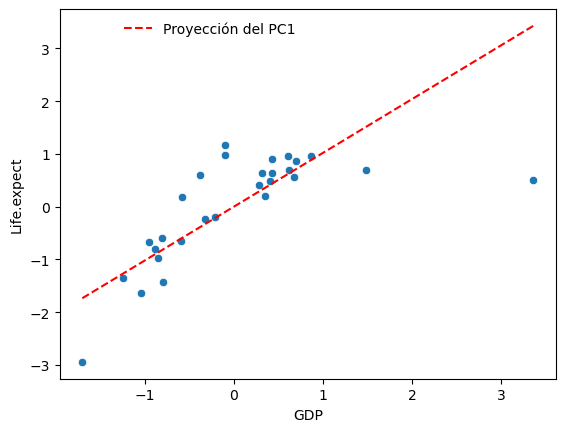

In [10]:
sns.scatterplot(
    data=norm_data,
    x="GDP",
    y="Life.expect",
)

factor = loadings["Life.expect"] / loadings["GDP"]

plt.plot(
    [norm_data.GDP.min(), norm_data.GDP.max()],
    [norm_data.GDP.min() * factor, norm_data.GDP.max() * factor],
    linestyle="dashed",
    color="red",
    label="Proyección del PC1"
)

plt.legend(bbox_to_anchor=(0.5, 1), frameon=False)
plt.show()